In [ ]:
!nvidia-smi
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import torch
import torch.nn as nn
import numpy as np
import os
import torchvision
print(torch.__version__)
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
print(torch.cuda.is_available())

Mon Jan 31 08:20:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

fmnist_train = datasets.FashionMNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
fmnist_test = datasets.FashionMNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

train_loader = DataLoader(dataset=fmnist_train, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=fmnist_test, batch_size=100, shuffle=False)

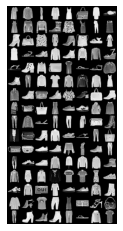

In [ ]:
import matplotlib.pyplot as plt
def imshow(img):
    # img = img / 2 + 0.5     # denormalize
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader) # iterator
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [ ]:
import torch.nn.functional as F
class NeuralNet(nn.Module):
    def __init__(self,  input_size, hidden_size1, hidden_size2, output_size):
        super(NeuralNet, self).__init__()
        self.fc1= nn.Linear(input_size, hidden_size1)
        self.fc2= nn.Linear(hidden_size1, hidden_size2)
        self.fc3= nn.Linear(hidden_size2, output_size)
        self.dropout_prob = 0.5
        self.sigmoid = nn.Sigmoid()
        self.batch_norm1 = nn.BatchNorm1d(512)
        self.batch_norm2 = nn.BatchNorm1d(256)

    def forward(self,x):
        x = self.fc1(x)
        x = self.batch_norm1(x)    # 각 레이어마다 분포가 달라지기 때문에 batchNorm을 사용하여 학습 속도 높임.
        x = self.sigmoid(x)
        x = F.dropout(x, training=self.training, p=self.dropout_prob)   #dropout을 이용하여 과적합 방지.
        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = self.sigmoid(x)
        x = F.dropout(x, training=self.training, p=self.dropout_prob)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
import torch.nn.init as init # 초기화 관련 모듈 
def weight_init(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight.data)

In [ ]:
model = NeuralNet(28*28, 512, 256, 10).to("cuda")
model.apply(weight_init)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(30):
    for i, (images,labels) in enumerate(train_loader):
        images = images.reshape(-1, 28*28).to("cuda")
        labels = labels.to("cuda")
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) ==(len(train_loader)//3) or (i+1) == (len(train_loader)//3)*2 or (i+1) ==len(train_loader):
            print(f"Epoch [{epoch+1}/30], Step [{i+1}/{len(train_loader)}], Loss: {round(loss.item(),4)}")

Epoch [1/30], Step [156/469], Loss: 0.5712
Epoch [1/30], Step [312/469], Loss: 0.4684
Epoch [1/30], Step [469/469], Loss: 0.4829
Epoch [2/30], Step [156/469], Loss: 0.6359
Epoch [2/30], Step [312/469], Loss: 0.493
Epoch [2/30], Step [469/469], Loss: 0.61
Epoch [3/30], Step [156/469], Loss: 0.4751
Epoch [3/30], Step [312/469], Loss: 0.3807
Epoch [3/30], Step [469/469], Loss: 0.5547
Epoch [4/30], Step [156/469], Loss: 0.3748
Epoch [4/30], Step [312/469], Loss: 0.3383
Epoch [4/30], Step [469/469], Loss: 0.5933
Epoch [5/30], Step [156/469], Loss: 0.4148
Epoch [5/30], Step [312/469], Loss: 0.3671
Epoch [5/30], Step [469/469], Loss: 0.3397
Epoch [6/30], Step [156/469], Loss: 0.3208
Epoch [6/30], Step [312/469], Loss: 0.3639
Epoch [6/30], Step [469/469], Loss: 0.3519
Epoch [7/30], Step [156/469], Loss: 0.2761
Epoch [7/30], Step [312/469], Loss: 0.3284
Epoch [7/30], Step [469/469], Loss: 0.2858
Epoch [8/30], Step [156/469], Loss: 0.3445
Epoch [8/30], Step [312/469], Loss: 0.4277
Epoch [8/30], 

In [ ]:
with torch.no_grad():
    correct =0 ; total=0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to("cuda")
        labels = labels.to("cuda")
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy of the network on the 10000 test images: {100*correct /total} %")
print(predicted.shape)

Accuracy of the network on the 10000 test images: 87.06 %
torch.Size([100])


In [ ]:
#epoch 10 -> 83.81%
#epoch 20 -> 85.30%         784, 20, 10
#epoch 30 -> 86.31%  에포크를 40으로 변경했을 때는 성능 향상이 살짝 되지만 오래걸려서 30으로 진행.
#epoch 30 -> 86.58%  레이어 변경
#sigmoid->ReLU -> 85.59%
#batch_szie 32 -> 256 : 86.87 %
#optimizer adam->SGD : 80.27% ?
#batch_szie 256 -> 128 : 87.06 %

In [ ]:
print(model)

NeuralNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (batch_norm1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch_norm2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [ ]:
fmnist_train, fmnist_val = torch.utils.data.random_split(fmnist_train, [50000, 10000])

ValueError: ignored

In [ ]:
dataloaders = {}
dataloaders['train'] = DataLoader(fmnist_train, batch_size=128, shuffle=True)
dataloaders['val'] = DataLoader(fmnist_val, batch_size=128, shuffle=False)
dataloaders['test'] = DataLoader(fmnist_test, batch_size=100, shuffle=False)

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 100),
            nn.Sigmoid(),
            nn.Linear(100,30),
            nn.Sigmoid()
        )
        self.decoder = nn.Sequential(
            nn.Linear(30,100),
            nn.Sigmoid(),
            nn.Linear(100, 28*28),
            nn.Sigmoid()
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(-1, 28*28)
        encoded = self.encoder(x)
        out = self.decoder(encoded).view(batch_size, 1, 28, 28)
        return out, encoded

In [ ]:
model = Autoencoder().to("cuda")
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
import time; import copy
def train_model(model, dataloaders, criterion, optimizer, num_epochs=10):
    since= time.time()
    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print("-"*10)
        for phase in ["train","val"]:
            if phase =="train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0

            for inputs, labels in dataloaders[phase]:
                #noise = torch.zeros(inputs.size(0), 1, 28, 28)   점수가 내려가서 노이즈 제거
                #nn.init.normal_(noise, 0, 0.1)
                #noise=noise.to("cuda")
                inputs = inputs.to("cuda")
                #noise_inputs= inputs + noise
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase=="train"):
                    outputs, encoded = model(inputs)
                    loss = criterion(outputs, inputs)

                    if phase =="train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()*inputs.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {round(epoch_loss,4)}')

            if phase=="train": train_loss_history.append(epoch_loss)
            if phase=="val": val_loss_history.append(epoch_loss)
            if phase=="val" and epoch_loss < best_val_loss:
                best_val_loss=epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()
    time_elapsed = time.time()-since
    print(f'Time in {time_elapsed // 60}m {time_elapsed % 60}s')
    print('Best val Loss {round(best_val_loss,4)}')
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [ ]:
best_model, train_loss_history, val_loss_history = train_model(model, dataloaders, loss_func, optimizer, num_epochs=30)

Epoch 0/29
----------
train Loss: 0.0443
val Loss: 0.0286

Epoch 1/29
----------
train Loss: 0.0249
val Loss: 0.0238

Epoch 2/29
----------
train Loss: 0.0212
val Loss: 0.0199

Epoch 3/29
----------
train Loss: 0.0194
val Loss: 0.0191

Epoch 4/29
----------
train Loss: 0.018
val Loss: 0.0174

Epoch 5/29
----------
train Loss: 0.017
val Loss: 0.0166

Epoch 6/29
----------
train Loss: 0.0162
val Loss: 0.0159

Epoch 7/29
----------
train Loss: 0.0156
val Loss: 0.0154

Epoch 8/29
----------
train Loss: 0.0151
val Loss: 0.0147

Epoch 9/29
----------
train Loss: 0.0146
val Loss: 0.0145

Epoch 10/29
----------
train Loss: 0.0142
val Loss: 0.014

Epoch 11/29
----------
train Loss: 0.0138
val Loss: 0.0138

Epoch 12/29
----------
train Loss: 0.0136
val Loss: 0.0136

Epoch 13/29
----------
train Loss: 0.0133
val Loss: 0.0132

Epoch 14/29
----------
train Loss: 0.0131
val Loss: 0.0129

Epoch 15/29
----------
train Loss: 0.0128
val Loss: 0.0131

Epoch 16/29
----------
train Loss: 0.0128
val Loss: 0

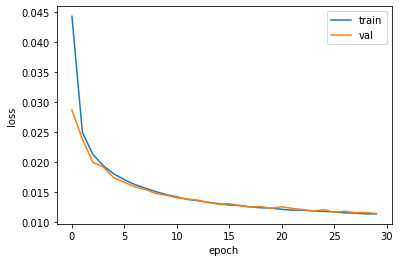

In [ ]:
# Let's draw a learning curve like below.
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
with torch.no_grad():
    running_loss = 0.0
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to("cuda")

        outputs, encoded = best_model(inputs)
        test_loss = loss_func(outputs, inputs)
        
        running_loss += test_loss.item() * inputs.size(0)

    test_loss = running_loss / len(dataloaders["test"].dataset)
    print(test_loss)        

0.011454547168686985


In [ ]:
# 노이즈 없을 때 0.011454547168686985
# 노이즈 있을 때 0.012621484589576721

torch.Size([100, 28, 28])


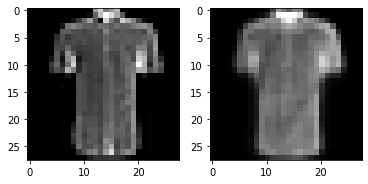

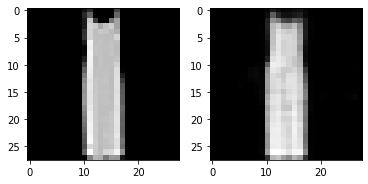

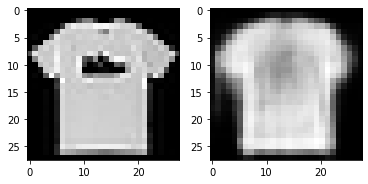

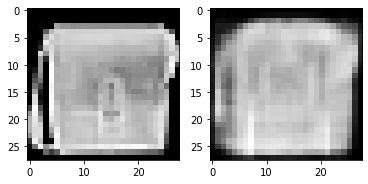

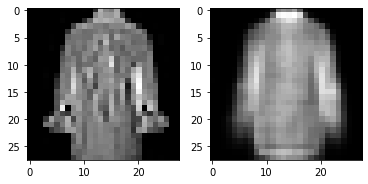

In [ ]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder,self).__init__()
        self.encoder= nn.Sequential(
            nn.Linear(28*28, 512),
            nn.Sigmoid(),
            nn.Linear(512,256),
            nn.Sigmoid(),
            #nn.Linear(256,128),
            #nn.Sigmoid(),
            #nn.Linear(128,64),
            #nn.Sigmoid()
        )
        self.fc_mu = nn.Linear(256, 10)
        self.fc_var = nn.Linear(256, 10)

        self.decoder = nn.Sequential(
            #nn.Linear(10,64),
            #nn.Sigmoid(),
            #nn.Linear(64,128),
            #nn.Sigmoid(),
            nn.Linear(10,256),
            nn.Sigmoid(),
            nn.Linear(256,512),
            nn.Sigmoid(),
            nn.Linear(512,28*28),
            nn.Sigmoid()
        )
        def encode(self, x):
            h=self.encoder(x)
            mu= self.fc_mu(h)
            log_var = self.fc_var(h)
            return mu, log_var

        def reparameterize(self, mu, log_var):
            std = torch.exp(0.5*log_var)
            eps = torch.randn_like(std)
            return mu + eps*std

        def decode(self, z):
            recon = self.decoder(z)
            return recon

        def forward(self, x):
            batch_size = x.size(0)
            mu,log_var = self.encode(x.view(batch_size, -1))
            z = self.reparameterize(mu, log_var)
            out = self.decode(z)
            return out, mu, log_var

In [ ]:
BCE =torch.nn.BCELoss(reduction="sum")
def loss_func(x, recon_x, mu, log_var):
    BCE_loss = BCE(recon_x, x.view(-1, 784))
    KLD_loss = -0.5 * torch.sum(1+log_var-mu.pow(2)-log_var.exp())
    return BCE_loss + KLD_loss

In [ ]:
model = VariationalAutoencoder().to("cuda")
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def train_VAE_model(model, dataloaders, criterion, optimizer, num_epochs=30):
    since = time.time()
    train_loss_history = []
    val_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ["train", "val"]:
            if phase =="train":
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to("cuda")
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs, mu, log_var = model(inputs)
                    loss = criterion(inputs, outputs, mu, log_var)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item()
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print(f'{phase} Loss: {round(epoch_loss,4)}')

            if phase == 'train': train_loss_history.append(epoch_loss)
            if phase == 'val': val_loss_history.append(epoch_loss)
            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history

In [ ]:
best_model, train_loss_history, val_loss_history = train_VAE_model(model, dataloaders, loss_func, optimizer,30)

Epoch 0/29
----------


NotImplementedError: ignored

In [ ]:
with torch.no_grad():
    running_loss = 0.0
    for inputs, labels in dataloaders["test"]:
        inputs = inputs.to("cuda")

        outputs, mu, log_var = best_model(inputs)
        test_loss = loss_func(inputs, outputs, mu, log_var)
        
        running_loss += test_loss.item()

    test_loss = running_loss / len(dataloaders["test"].dataset)
    print(test_loss)        

In [ ]:
out_img = torch.squeeze(outputs.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1,2,1)
    plt.imshow(torch.squeeze(inputs[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(out_img[i].numpy().reshape(28, 28),cmap='gray')
    plt.show()